<a href="https://colab.research.google.com/github/YuToyoshima/python_samples/blob/main/weathervane_parallel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 風見鶏機構のモデル

Izquierdo and Lockery 2010 J. Neurosci. のモデルをpythonで実装してみました。
原点を頂点とした仮想的な濃度勾配空間に仮想線虫を置いて、シミュレーションしてみます。
パラメータをうまく最適化してあげると、線虫の塩走性行動における風見鶏機構のように、原点に向かって曲がりながら進むようになります。

このバージョンは全個体まとめて並列に計算するparallelバージョンで、モデルのパラメータ最適化に適しています。

In [11]:
# GPU対応 PyTorch 実装 (MATLAB -> PyTorch)
import torch
import math
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# ---------------------------
# 基本関数
# ---------------------------
def nacl_torch(x, y):
    # x,y: (B,) tensor
    return x * x + y * y

def sigmoid_torch(x, theta):
    # x: (B,) or scalar, theta: scalar or (B,)
    return 1.0 / (1.0 + torch.exp(-(x + theta)))

# ---------------------------
# simulate_par: バッチ版
# ---------------------------
def simulate_par(init, param, numloop=5000, device=device):
    """
    init: (numAnimal,3) tensor (x0,y0,mu0) on device or cpu
    param: (numAnimal,8) tensor (m,n,w_on,w_off,w_osc,w_self,w_nmj,theta)
           each row corresponds to one animal
    returns: x,y as numpy arrays shape (numAnimal, numloop+1) on CPU
    """
    # ensure tensors on device
    init = torch.as_tensor(init, device=device, dtype=torch.float32)
    param = torch.as_tensor(param, device=device, dtype=torch.float32)

    dt = 0.1
    tau = 0.1
    v = 0.022

    numAnimal = param.shape[0]

    # parameters per animal
    # m,n are given in seconds in MATLAB code then rounded by dt; param[:,0] and param[:,1] represent times (m,n)
    m = (param[:, 0] / dt).round().long()  # (numAnimal,)
    n = (param[:, 1] / dt).round().long()
    w_on   = param[:, 2]  # (numAnimal,)
    w_off  = param[:, 3]
    w_osc  = param[:, 4]
    w_self = param[:, 5]
    w_nmj  = param[:, 6]
    theta  = param[:, 7]

    # initial values
    x0 = init[:, 0]
    y0 = init[:, 1]
    mu0 = init[:, 2]

    # buffers
    x = torch.zeros((numAnimal, numloop + 1), device=device)
    y = torch.zeros((numAnimal, numloop + 1), device=device)
    mu = torch.zeros((numAnimal, numloop + 1), device=device)

    x[:, 0] = x0
    y[:, 0] = y0
    mu[:, 0] = mu0

    activity = torch.zeros((numAnimal, numloop + 1), device=device)
    MND = torch.zeros((numAnimal, numloop + 1), device=device)
    MNV = torch.zeros((numAnimal, numloop + 1), device=device)

    maxlag = int(torch.max(m + n).item())  # scalar python int

    # conc_timelapse_all: (numAnimal, numloop + maxlag)
    conc_timelapse_all = torch.zeros((numAnimal, numloop + maxlag), device=device)
    # initialize first values: MATLAB used repmat(nacl(x(:,1),y(:,1)),[1,maxlag-1])
    # we'll fill first maxlag entries with nacl(x0,y0)
    conc0 = nacl_torch(x0, y0)  # (numAnimal,)
    conc_timelapse_all[:, :maxlag] = conc0.unsqueeze(1).repeat(1, maxlag)

    # Prepare sensory coefficients per animal: coeff_sensory (numAnimal, maxlag)
    coeff_sensory = torch.zeros((numAnimal, maxlag), device=device)
    for ai in range(numAnimal):
        mm = int(m[ai].item())
        nn = int(n[ai].item())
        if nn > 0:
            coeff_sensory[ai, maxlag - nn : maxlag] = 1.0 / nn
        if mm > 0:
            start = maxlag - nn - mm
            end = maxlag - nn
            if start < 0:
                # guard: if mm extends before index 0, clip
                start = 0
            coeff_sensory[ai, start:end] = -1.0 / mm

    # vectorized sensory: sensory_par(conc_timelapse, coeff_sensory) -> sum(conc_timelapse * coeff_sensory, dim=1)
    # main loop (time)
    #two_pi_dt_over_4p2 = 2.0 * math.pi * dt / 4.2
    two_pi_dt_over_4p2 = torch.tensor(2 * math.pi * dt / 4.2, device=device, dtype=torch.float32)

    for p in range(numloop):
        # put new concentration at time index maxlag-1 + p
        conc_timelapse_all[:, maxlag - 1 + p] = nacl_torch(x[:, p], y[:, p])
        # conc_timelapse window for this step: columns p : p+maxlag
        conc_timelapse = conc_timelapse_all[:, p : p + maxlag]  # shape (numAnimal, maxlag)

        # sensory: (numAnimal,)
        activity[:, p + 1] = torch.sum(conc_timelapse * coeff_sensory, dim=1)

        # I_on and I_off
        isPositive = activity[:, p + 1] > 0
        I_on  = w_on * activity[:, p + 1] * isPositive.to(activity.dtype)
        # In MATLAB I_off = w_off.*-activity(:,p+1).*~isPositive;
        I_off = w_off * (-activity[:, p + 1]) * (~isPositive).to(activity.dtype)

        # oscillator scalar then broadcast
        y_osc = torch.sin((p + 1) * two_pi_dt_over_4p2)  # scalar tensor (float)
        # Broadcast to shape (numAnimal,)
        I_osc = w_osc * y_osc

        # neuron updates (use tau)
        MND[:, p + 1] = MND[:, p] + (-MND[:, p] + w_self * sigmoid_torch(MND[:, p], theta) + I_on + I_off + I_osc) * (dt / tau)
        MNV[:, p + 1] = MNV[:, p] + (-MNV[:, p] + w_self * sigmoid_torch(MNV[:, p], theta) + I_on + I_off - I_osc) * (dt / tau)

        # mu update
        mu[:, p + 1] = mu[:, p] + dt * w_nmj * (sigmoid_torch(MND[:, p + 1], theta) - sigmoid_torch(MNV[:, p + 1], theta))

        # position update
        x[:, p + 1] = x[:, p] + dt * v * torch.cos(mu[:, p + 1])
        y[:, p + 1] = y[:, p] + dt * v * torch.sin(mu[:, p + 1])

    # return to CPU numpy for compatibility with plotting etc.
    return x.detach().cpu().numpy(), y.detach().cpu().numpy()


# ---------------------------
# objfun implementations
# ---------------------------
def objfun_par(param, numtrials=20, startdist=4.5, numloop=5000, device=device):
    """
    param: 1D array-like length 8 (single parameter vector)
    returns: scalar score (float)
    """
    # param to tensor and replicate for each trial
    param = torch.as_tensor(param, device=device, dtype=torch.float32)
    # prepare batch in which each row is same param
    param_batch = param.unsqueeze(0).repeat(numtrials, 1)  # (numtrials,8)

    # random initial conditions for numtrials
    angles = torch.rand(numtrials, device=device) * 2.0 * math.pi
    x0 = startdist * torch.cos(angles)
    y0 = startdist * torch.sin(angles)
    mu0 = torch.rand(numtrials, device=device) * 2.0 * math.pi
    init = torch.stack([x0, y0, mu0], dim=1)  # (numtrials,3)

    x, y = simulate_par(init, param_batch, numloop=numloop, device=device)  # numpy arrays
    # compute temporal mean distance per trial
    dist_mean = np.mean(np.sqrt(x * x + y * y), axis=1)  # shape (numtrials,)
    tmpscore = dist_mean / startdist
    score = float(np.mean(tmpscore))
    return score


def objfun_par2(param, numtrials=20, startdist=4.5, numloop=5000, device=device):
    """
    param: array-like shape (numIndividuals,8)
    returns: scores per individual (numpy array shape (numIndividuals,))
    """
    param = np.asarray(param, dtype=np.float32)
    numIndividuals = param.shape[0]
    # Build param_batch that repeats each individual's param numtrials times in sequence
    # total trials = numIndividuals * numtrials
    total_trials = numIndividuals * numtrials

    # in MATLAB, they create init for total_trials and pass param repeated [numtrials,1] which tiles rows
    # So we repeat each param row numtrials times
    param_batch = np.repeat(param, repeats=numtrials, axis=0)  # (total_trials,8)

    angles = np.random.rand(total_trials) * 2.0 * math.pi
    x0 = startdist * np.cos(angles)
    y0 = startdist * np.sin(angles)
    mu0 = np.random.rand(total_trials) * 2.0 * math.pi
    init = np.stack([x0, y0, mu0], axis=1)  # (total_trials,3)

    x, y = simulate_par(init, param_batch, numloop=numloop, device=device)  # numpy arrays
    dist_mean = np.mean(np.sqrt(x * x + y * y), axis=1) / startdist  # shape (total_trials,)

    # reshape into (numIndividuals, numtrials), then mean across trials -> (numIndividuals,)
    tmpscore = dist_mean.reshape(numIndividuals, numtrials)
    scores = tmpscore.mean(axis=1)
    return scores  # numpy array


# ---------------------------
# visualizeResult
# ---------------------------
def visualizeResult(param, numtrials=20, startdist=4.5, numloop=5000, device=device):
    """
    param: array-like shape (8,) or (numIndividuals,8)
    If param is a single vector, will replicate for numtrials.
    """
    param = np.asarray(param, dtype=np.float32)
    if param.ndim == 1:
        param_batch = np.repeat(param[np.newaxis, :], repeats=numtrials, axis=0)
    else:
        # if multiple individuals provided, use first
        param_batch = np.repeat(param[0:1, :], repeats=numtrials, axis=0)

    angles = np.random.rand(numtrials) * 2.0 * math.pi
    x0 = startdist * np.cos(angles)
    y0 = startdist * np.sin(angles)
    mu0 = np.random.rand(numtrials) * 2.0 * math.pi
    init = np.stack([x0, y0, mu0], axis=1)

    x, y = simulate_par(init, param_batch, numloop=numloop, device=device)

    # plot trajectories
    plt.figure(figsize=(6, 6))
    ct = np.linspace(-1 * np.pi, np.pi, 100)
    cx = startdist*np.cos(ct)
    cy = startdist*np.sin(ct)
    plt.plot(cx,cy,'k:')
    for i in range(x.shape[0]):
        plt.plot(x[i, :], y[i, :], linewidth=0.8, alpha=0.8)
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Trajectories")
    plt.grid(True)
    plt.show()

device: cpu


In [ ]:
!pip install pymoo torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.8/303.8 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.0.0
    Uninstalling wrapt-2.0.0:
      Successfully uninstalled wrapt-2.0.0


In [ ]:
# ---------------------------
# pymoo用ラッパーとGA設定
# ---------------------------
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.core.callback import Callback
import time


# 目的関数ラッパー
def objfun_for_pymoo(x):
    """
    x: 2D array shape (numIndividuals, 8)
    returns: 1D array shape (numIndividuals,)
    """
    scores = objfun_par2(x, numtrials=20, startdist=4.5, numloop=5000, device=device)
    # pymooは最小化問題なので、スコアが高い方が良い場合は反転
    return scores

# pymoo Problem 定義
class MyProblem(Problem):
    def __init__(self):
        super().__init__(
            n_var=8,            # パラメータ数
            n_obj=1,            # 1目的
            n_constr=0,         # 制約なし
            xl = np.array([0.1, 0.1, -15, -15,  0,  0, 1, -15]),
            xu = np.array([4.2, 4.2,  15,  15, 15, 15, 3,  15])
        )

    def _evaluate(self, X, out, *args, **kwargs):
        # X: (pop_size, n_var)
        # out["F"]: (pop_size, n_obj)
        scores = objfun_for_pymoo(X)
        # GAは最小化問題のため、スコアをそのまま返す
        out["F"] = scores.reshape(-1, 1)


class MyCallback(Callback):
    def __init__(self):
        super().__init__()
        self.best_per_gen = []
        self.mean_per_gen = []
        self.worst_per_gen = []
        self.elapsed_time = []
        self.start_time = None

    def notify(self, algorithm):
        if self.start_time is None:
            self.start_time = time.time()  # 最初の世代で開始時刻を記録

        F = algorithm.pop.get("F").flatten()  # 目的関数値 (pop_size,)
        best = np.min(F)
        mean = np.mean(F)
        worst = np.max(F)
        elapsed = time.time() - self.start_time

        # データを蓄積
        self.best_per_gen.append(best)
        self.mean_per_gen.append(mean)
        self.worst_per_gen.append(worst)
        self.elapsed_time.append(elapsed)

        # ログ表示
        print(f"Gen {algorithm.n_gen:3d} | Best: {best:.6f} | Mean: {mean:.6f} | Worst: {worst:.6f} | Elapsed: {elapsed:.1f} s")


In [ ]:

# ---------------------------
# GA 実行
# ---------------------------
problem = MyProblem()

algorithm = NSGA2(
    pop_size=20,
    sampling=FloatRandomSampling(),
    crossover=SimulatedBinaryCrossover(prob=0.9, eta=15),
    mutation=PolynomialMutation(eta=20),
    eliminate_duplicates=True
)

res = minimize(
    problem,
    algorithm,
    ('n_gen', 10),  # 世代数
    verbose=False,
    callback=MyCallback()
)

# ---------------------------
# 結果表示
# ---------------------------
print("Best parameters found:")
print(res.X)
print("Best score:")
print(res.F)

# T4 GPU: 45 sec (parallel version)
# CPU: 36 sec (parallel version)
# CPU: 589 sec (serial version)


Gen   1 | Best: 1.015625 | Mean: 1.494215 | Worst: 2.155500 | Elapsed: 0.0 s
Gen   2 | Best: 0.964689 | Mean: 1.221826 | Worst: 1.451242 | Elapsed: 4.7 s
Gen   3 | Best: 0.828975 | Mean: 1.068192 | Worst: 1.229905 | Elapsed: 9.2 s
Gen   4 | Best: 0.622821 | Mean: 0.953435 | Worst: 1.056944 | Elapsed: 14.6 s
Gen   5 | Best: 0.488850 | Mean: 0.827686 | Worst: 0.986285 | Elapsed: 18.9 s
Gen   6 | Best: 0.418161 | Mean: 0.700321 | Worst: 0.874734 | Elapsed: 23.0 s
Gen   7 | Best: 0.400880 | Mean: 0.536163 | Worst: 0.685283 | Elapsed: 28.2 s
Gen   8 | Best: 0.382476 | Mean: 0.446425 | Worst: 0.491766 | Elapsed: 32.4 s
Gen   9 | Best: 0.378963 | Mean: 0.407289 | Worst: 0.445188 | Elapsed: 36.6 s
Gen  10 | Best: 0.346531 | Mean: 0.386913 | Worst: 0.402805 | Elapsed: 41.7 s
Best parameters found:
[ 1.37215668  1.22909266 -5.10372434  6.82884982  4.47898922  6.94909583
  2.0826932  -0.46792192]
Best score:
[0.34653056]


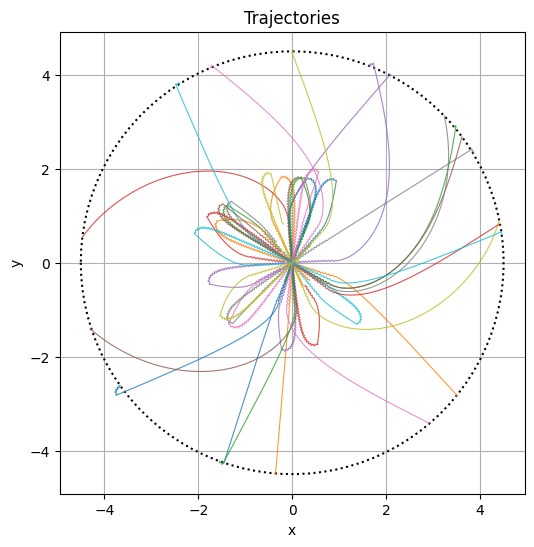

In [12]:
visualizeResult(res.X)

In [ ]:
import cProfile
import pstats

def run_optimization():
    res = minimize(
      problem,
      algorithm,
      ('n_gen', 10),  # 世代数
      verbose=False,
      callback=MyCallback()
    )
    return res

cProfile.run('run_optimization()', 'profile_result')

# 結果を整形して表示
p = pstats.Stats('profile_result')
p.sort_stats('cumulative').print_stats(20)  # 上位20件を表示

Gen   1 | Best: 0.717901 | Mean: 1.377459 | Worst: 2.000606 | Elapsed: 0.0 s
Gen   2 | Best: 0.511099 | Mean: 1.076595 | Worst: 1.371228 | Elapsed: 4.5 s
Gen   3 | Best: 0.480404 | Mean: 0.794078 | Worst: 1.067850 | Elapsed: 10.4 s
Gen   4 | Best: 0.413804 | Mean: 0.664518 | Worst: 0.838599 | Elapsed: 15.2 s
Gen   5 | Best: 0.399933 | Mean: 0.554534 | Worst: 0.717901 | Elapsed: 20.3 s
Gen   6 | Best: 0.361783 | Mean: 0.464389 | Worst: 0.567537 | Elapsed: 25.2 s
Gen   7 | Best: 0.333546 | Mean: 0.391081 | Worst: 0.434875 | Elapsed: 29.8 s
Gen   8 | Best: 0.308215 | Mean: 0.357011 | Worst: 0.384849 | Elapsed: 37.6 s
Gen   9 | Best: 0.308215 | Mean: 0.347808 | Worst: 0.359503 | Elapsed: 42.3 s
Gen  10 | Best: 0.308215 | Mean: 0.340436 | Worst: 0.356529 | Elapsed: 48.1 s
Sat Oct 25 16:00:09 2025    profile_result

         1618206 function calls (1617416 primitive calls) in 52.384 seconds

   Ordered by: cumulative time
   List reduced from 444 to 20 due to restriction <20>

   ncalls  tot